# Test GEModelTools - HANK

This notebook shows how to **solve a simple Heterogenous Agent New Keynessian (HANK) model** using the `GEModelTools` package.

**The steps of the sequence-space solution method are:**

1. Find the stationary equilibrium (steady state for aggregates and distribution).
2. Compute Jacobians of the household block and the full model (to unknowns and shocks)
3. Find the non-linear transition path or the linearized impulse responses to a given shock path.
4. Simulate the linearized model with aggregate risk

# Imports

In [1]:
%load_ext autoreload
%autoreload 2

import time
import pickle
import numpy as np
from scipy import optimize

import matplotlib.pyplot as plt   
plt.style.use('seaborn-whitegrid')
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

from HANKmodel import HANKModelClass

# Setup

In [2]:
model = HANKModelClass(name='baseline')
#print(model)

# Step 1: Steady state

In [3]:
model.find_ss(do_print=True)

Q = 0.5 M_L = 0.5 beta =  0.9875 N_L = 0.5
Q = 0.5 M_L = 0.5 beta =  0.9875 N_L = 0.5
Q = 0.5 M_L = 0.5 beta =  0.9875 N_L = 0.5
Q = 0.5 M_L = 0.5000000074505806 beta =  0.9875 N_L = 0.5
Q = 0.5 M_L = 0.5 beta =  0.9875 N_L = 0.5000000074505806
Q = 0.5 M_L = 0.5 beta =  0.9875000147148967 N_L = 0.5
Q = 0.5000000074505806 M_L = 0.5 beta =  0.9875 N_L = 0.5
Q = 0.9197540112251592 M_L = 0.22785969236324177 beta =  0.9865015850967607 N_L = 0.21687118932836313
Q = 0.7297597788801526 M_L = 0.4107544435634817 beta =  0.9871386091728198 N_L = 0.47526026919074155
Q = 0.9453236490070912 M_L = 0.14653464988680848 beta =  0.9865758373252353 N_L = 0.29805212935108777
Q = 0.9443035026118927 M_L = 0.2401519002565288 beta =  0.9865751413811293 N_L = 0.3860086907242252
Q = 0.9894189147217674 M_L = 0.160501784241829 beta =  0.9867428388215608 N_L = 0.3219555964439703
Q = 1.008815863691831 M_L = 0.17610469055669614 beta =  0.9866688510475424 N_L = 0.3431480776252151
Q = 1.0056981448004132 M_L = 0.1652832

In [4]:
model.solve_hh_ss(do_print=True)

household problem in ss solved in 0.5 secs [547 iterations]


In [5]:
par = model.par
ss = model.ss
path = model.path
sim = model.sim

In [6]:
print("Steady state W_L, W_N, Q = ", ss.w_L, ss.w_N, ss.Q)
print("Steady state B, G, A, A_HH, tau = ", ss.B, ss.G, ss.A, ss.A_hh, ss.tau)
#print("Steady state interest rate", ss.r)
print("steady state consumption C", ss.C_hh,"C_L", ss.Q*ss.C_L_hh,"C_N", ss.C_N_hh)
#print("Steady state laborsupply ell ", ss.ell)
print("varphi= ", par.varphi, "beta = ", par.beta)

Steady state W_L, W_N, Q =  0.9526811609219734 0.9585053571563809 1.0061134789615982
Steady state B, G, A, A_HH, tau =  5.6 0.0 5.6 5.5999999999979195 0.0
steady state consumption C 1.0617101246341014 C_L 0.3686894683712129 C_N 0.2681538827896187
varphi=  0.8 beta =  0.9866898059409461


## Policy functions

In [7]:
#fig = plt.figure(figsize=(18,4),dpi=100)
#a_max = 500
#
## a. consumption
#I = par.a_grid < a_max
#
#ax = fig.add_subplot(1,3,1)
#ax.set_title(f'consumption')
#
#for i_z in [0,par.Nz//2,par.Nz-1]:
#    ax.plot(par.a_grid[I],ss.c[0,i_z,I],label=f'i_z = {i_z}')
#
#ax.legend(frameon=True)
#ax.set_xlabel('savings, $a_{t-1}$')
#ax.set_ylabel('consumption, $c_t$')
#
## b. saving
#I = par.a_grid < a_max
#
#ax = fig.add_subplot(1,3,2)
#ax.set_title(f'saving')
#
#for i_z in [0,par.Nz//2,par.Nz-1]:
#    ax.plot(par.a_grid[I],ss.a[0,i_z,I],label=f'i_z = {i_z}')
#
#ax.set_xlabel('savings, $a_{t-1}$')
#ax.set_ylabel('savings, $a_{t}$')
#
## c. labor supply
#I = par.a_grid < a_max
#
#ax = fig.add_subplot(1,3,3)
#ax.set_title(f'labor_supply')
#
#for i_z in [0,par.Nz//2,par.Nz-1]:
#    ax.plot(par.a_grid[I],ss.ell[0,i_z,I],label=f'i_z = {i_z}')
#
#ax.set_xlabel('savings, $a_{t-1}$')
#ax.set_ylabel('labor supply, $n_{t}$')
#
#fig.tight_layout()

## Simulation

In [8]:
#fig = plt.figure(figsize=(12,4),dpi=100)
#
## a. income
#ax = fig.add_subplot(1,2,1)
#ax.set_title('productivity')
#
#y = np.cumsum(np.sum(ss.D[0],axis=1))
#ax.plot(par.z_grid,y/y[-1])
#
#ax.set_xlabel('productivity, $z_{t}$')
#ax.set_ylabel('CDF')
#
## b. assets
#ax = fig.add_subplot(1,2,2)
#ax.set_title('savings')
#y = np.insert(np.cumsum(np.sum(ss.D[0],axis=0)),0,0.0)
#ax.plot(np.insert(par.a_grid,0,par.a_grid[0]),y/y[-1])
#        
#ax.set_xlabel('assets, $a_{t}$')
#ax.set_ylabel('CDF')
#ax.set_xscale('symlog')


# Step 2: Compute Jacobians (incl. tests)

**Household transition path:**

note: inputs = steady state value -> expected: constant value (straigt line)

household problem solved along transition path in 1.4 secs
household problem simulated along transition in 4.1 secs



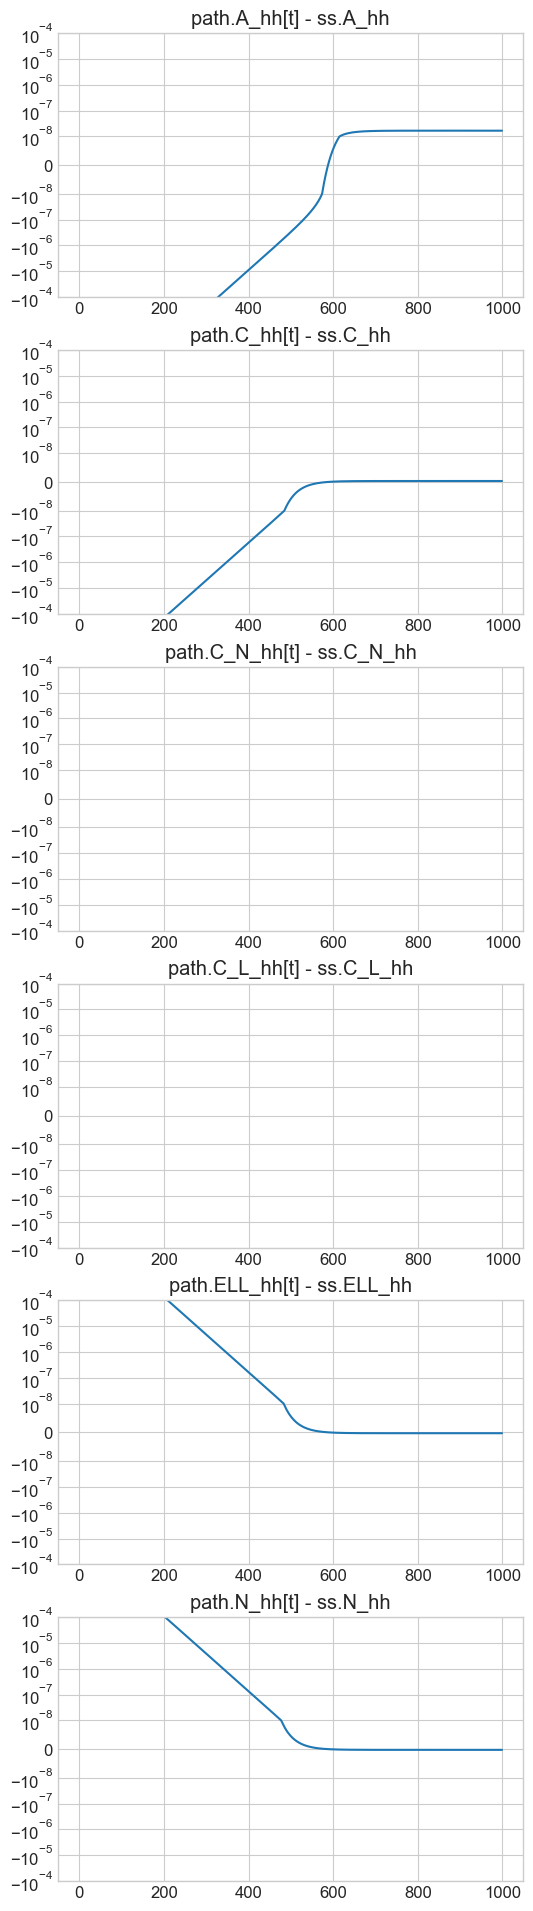

In [9]:
model.test_hh_path()

**Full transition path:**

In [10]:
model.test_path()

note: inputs = steady state value -> expected: no difference to steady state and zero errors

difference to value at steady state:
A              : t0 =  0.0e+00, max abs.  0.0e+00
B              : t0 =  0.0e+00, max abs.  0.0e+00
C_N            : t0 =  0.0e+00, max abs.  0.0e+00
C_L            : t0 =  1.8e-02, max abs.  1.8e-02
d_N            : t0 = -1.6e-02, max abs.  1.6e-02
d_L            : t0 =  3.9e-03, max abs.  3.9e-03
G              : t0 =  0.0e+00, max abs.  0.0e+00
i              : t0 =  0.0e+00, max abs.  0.0e+00
N              : t0 = -6.4e-01, max abs.  6.4e-01
N_N            : t0 = -2.2e-01, max abs.  2.2e-01
N_L            : t0 = -3.4e-01, max abs.  3.4e-01
M_N            : t0 =  0.0e+00, max abs.  0.0e+00
M_L            : t0 = -2.3e-02, max abs.  2.3e-02
pm             : t0 =  0.0e+00, max abs.  0.0e+00
pi_N           : t0 =  0.0e+00, max abs.  0.0e+00
pi_L           : t0 =  0.0e+00, max abs.  0.0e+00
adjcost_N      : t0 =  0.0e+00, max abs.  0.0e+00
adjcost_L      : t0

note: differences should only be due to numerical errors

direct method:
finding Jacobian wrt. ghost          : 50 100 150 [computed in 3.3 secs]
finding Jacobian wrt. Q              : 50 100 150 [computed in 3.0 secs]
finding Jacobian wrt. d_L            : 50 100 150 [computed in 2.8 secs]
finding Jacobian wrt. d_N            : 50 100 150 [computed in 2.7 secs]
finding Jacobian wrt. r              : 50 100 150 [computed in 2.7 secs]
finding Jacobian wrt. tau            : 50 100 150 [computed in 2.5 secs]
finding Jacobian wrt. w_N            : 50 100 150 [computed in 2.6 secs]
household Jacobian computed in 22.8 secs

fake news method:
one step deviation from steady state calculated in 0.0 secs
curly_Y and curly_D calculated for Q               in 1.8 secs
curly_Y and curly_D calculated for d_L             in 1.6 secs
curly_Y and curly_D calculated for d_N             in 1.8 secs
curly_Y and curly_D calculated for r               in 1.7 secs
curly_Y and curly_D calculated for tau      

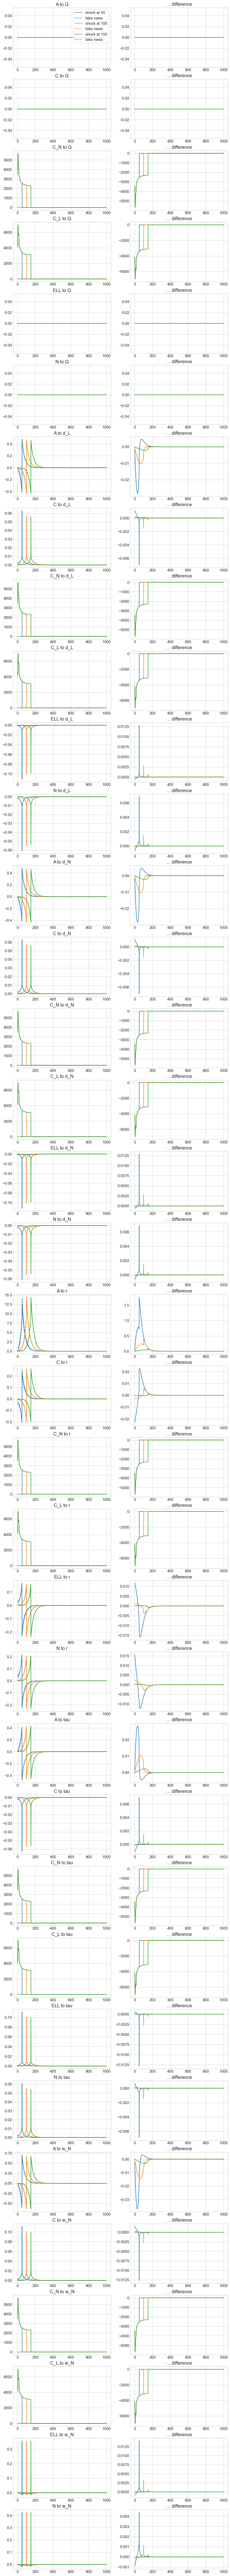

In [11]:
model.test_jacs(s_list=[50,100,150])

# Step 3a: Find non-linear transition path

## Find transition path

In [12]:
par.jump_pm = 0.10/4
model.find_transition_path(do_print=True)

finding the transition path:
 it =   0 -> max. abs. error = 5.42e+00
   1.43e-03 in NKPC_res_N
   7.10e-04 in NKPC_res_L
   5.42e+00 in clearing_A
   7.45e-01 in clearing_N
   2.29e-01 in clearing_C_N
   3.28e-01 in clearing_C_L
backtracking...
backtracking...
backtracking...
backtracking...
backtracking...
backtracking...
backtracking...
backtracking...
backtracking...
backtracking...
backtracking...
backtracking...
backtracking...
backtracking...
backtracking...
backtracking...
backtracking...
backtracking...
backtracking...
backtracking...
backtracking...
backtracking...
backtracking...
backtracking...
backtracking...
backtracking...
backtracking...
backtracking...
backtracking...
backtracking...


ValueError: GEModelTools: Number of backtracks exceeds 30

## Plot transitions

### shocks ###


c:\users\johan\onedrive\økonomi ku\speciale\github repositories\numeconcopenhagen\gemodeltools\GEModelTools\figures.py:109: RuntimeWarning: divide by zero encountered in true_divide
  ax.plot(np.arange(T_max),100*(pathvalue[:T_max]/ssvalue-1),label=label)


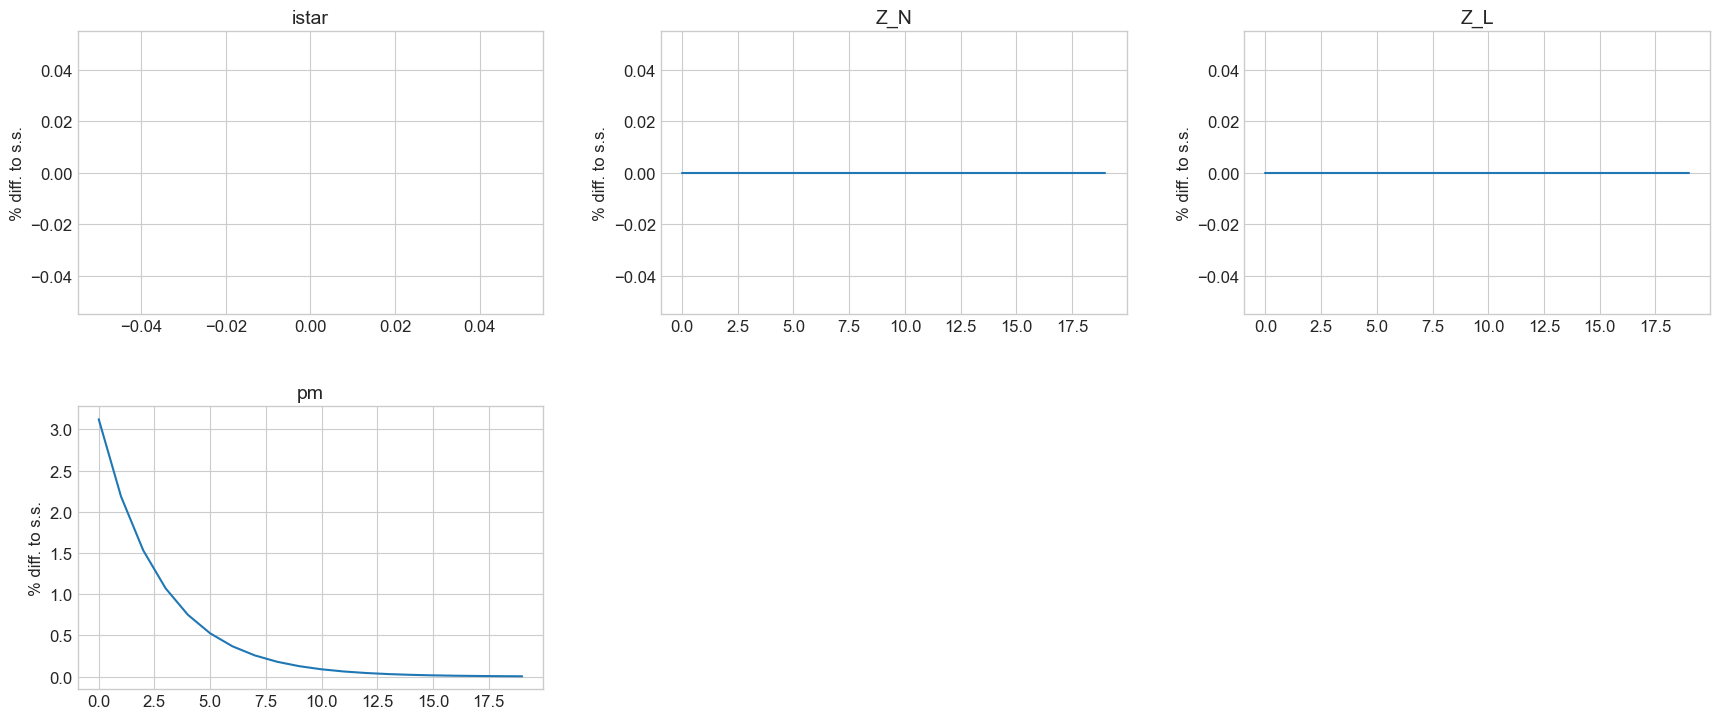


### varnames ###


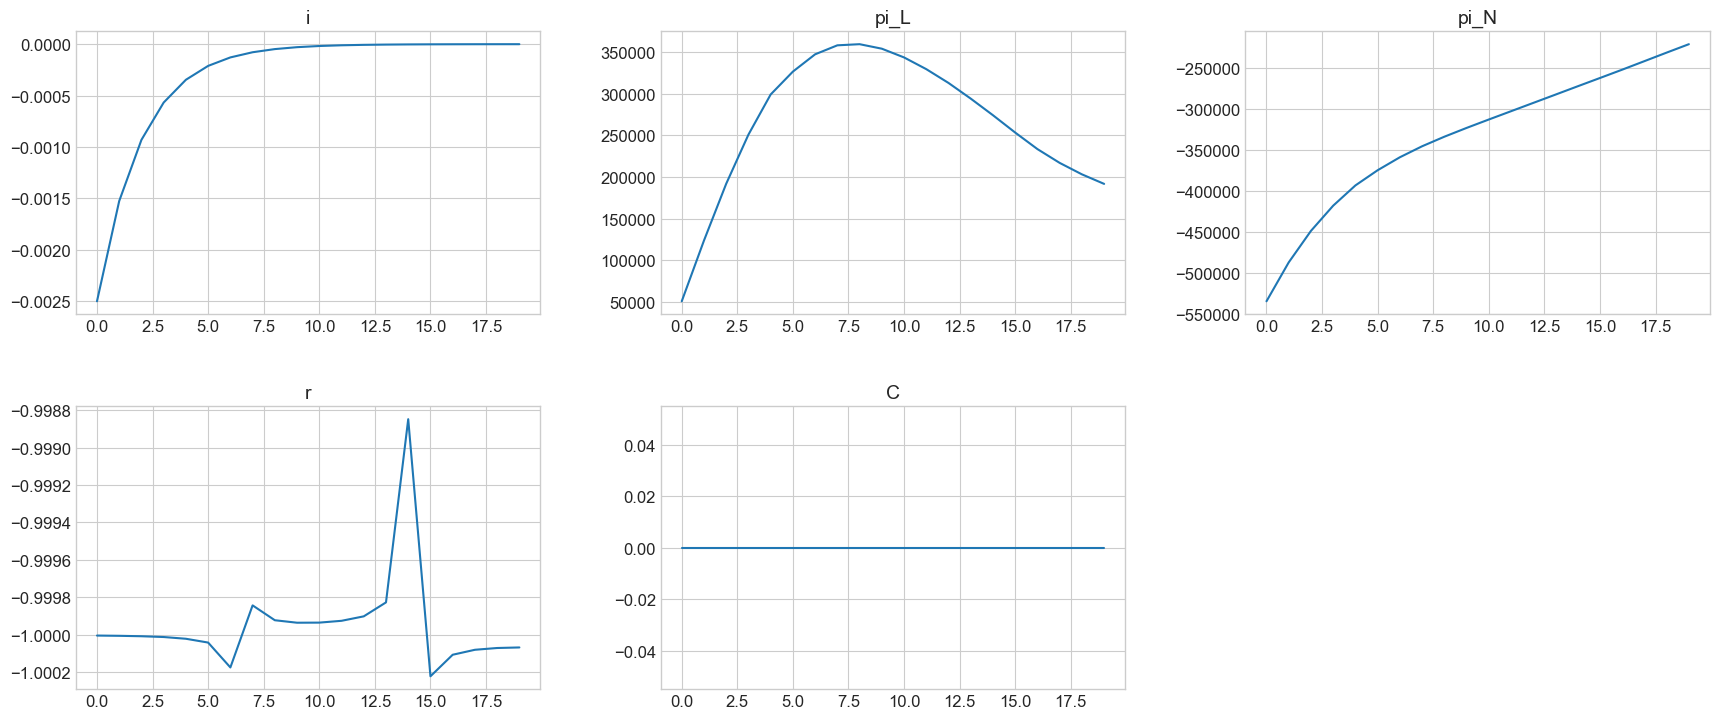


### tagets ###


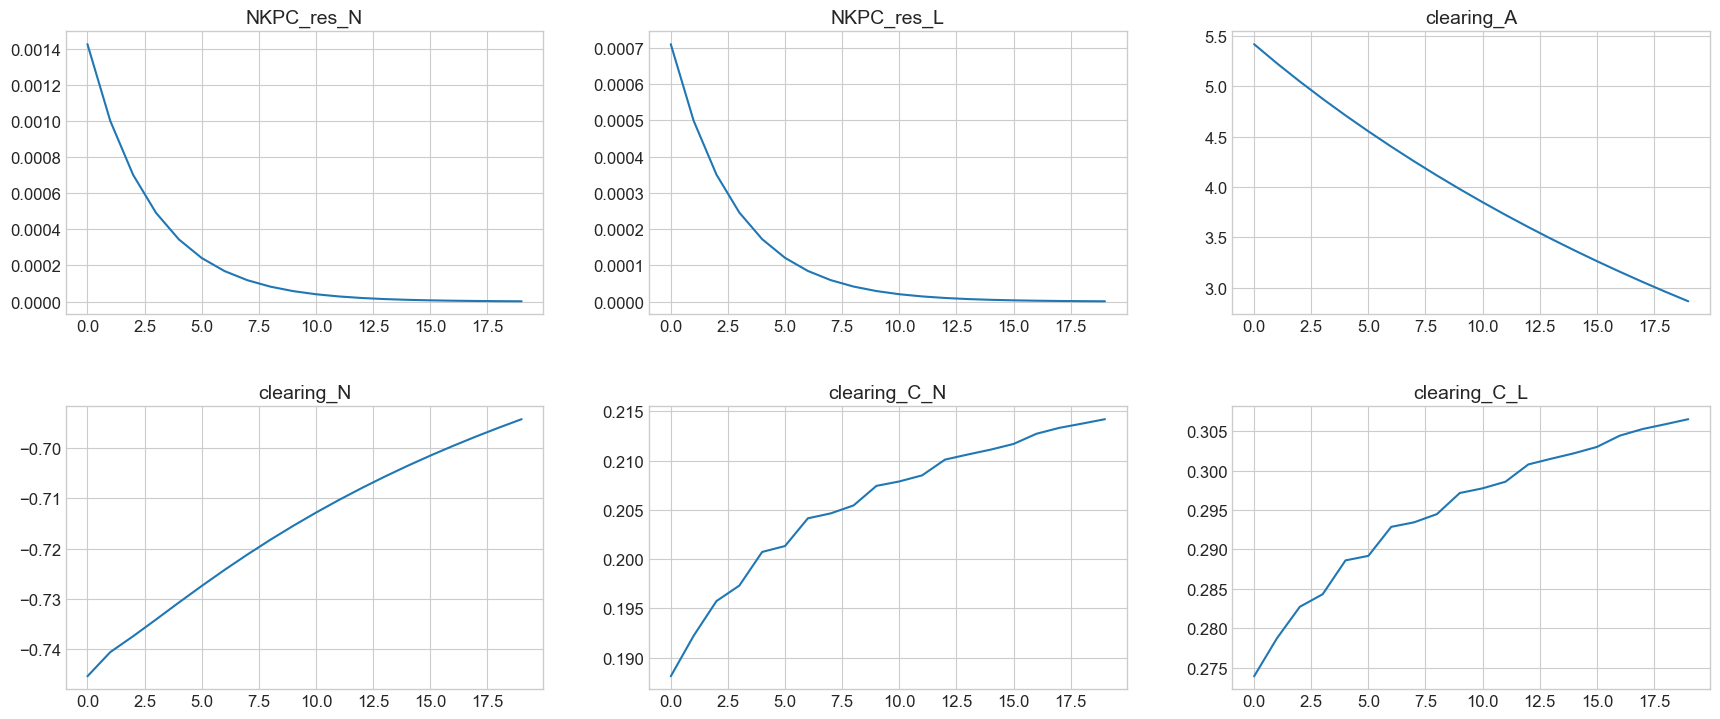

In [13]:
paths = ['i','pi_L','pi_N','r','C']
lvl_value = ['i','pi_L','pi_N','r']
model.show_IRFs(paths,lvl_value=lvl_value,T_max=20,ncols=3)

# Step 3b: Find linearized IRFs

In [14]:
model.find_IRFs(do_print=True)

linear transition path found in 7.7 secs [finding solution matrix: 7.2 secs]


### shocks ###


c:\users\johan\onedrive\økonomi ku\speciale\github repositories\numeconcopenhagen\gemodeltools\GEModelTools\figures.py:111: RuntimeWarning: divide by zero encountered in true_divide
  ax.plot(np.arange(T_max),100*(IRFvalue[:T_max]/ssvalue-1),ls='--',label='linear')


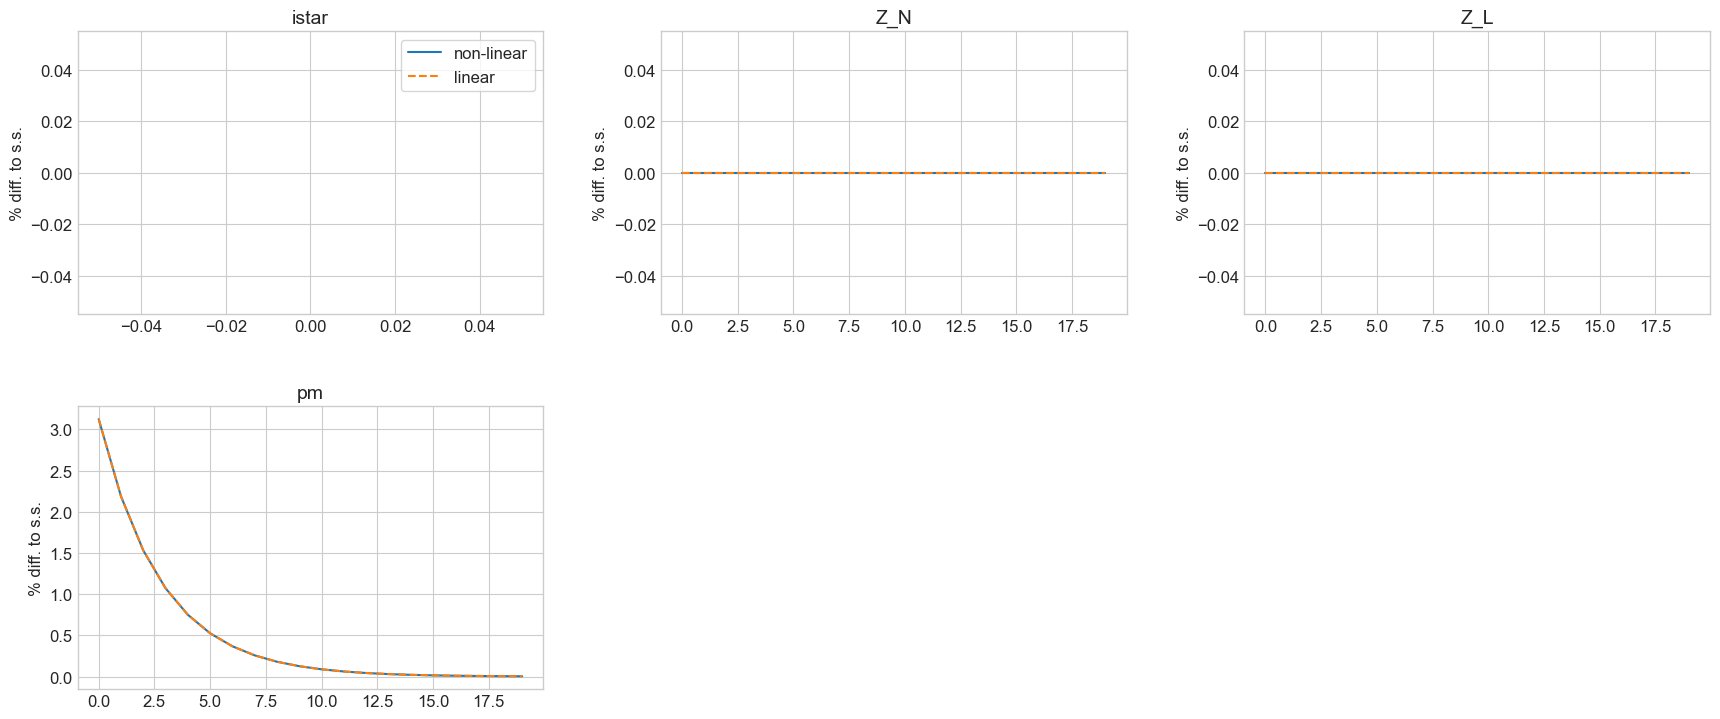


### varnames ###


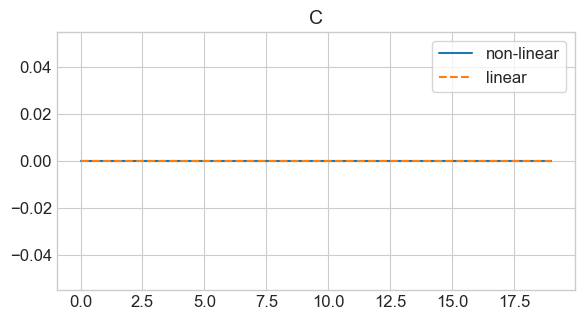


### tagets ###


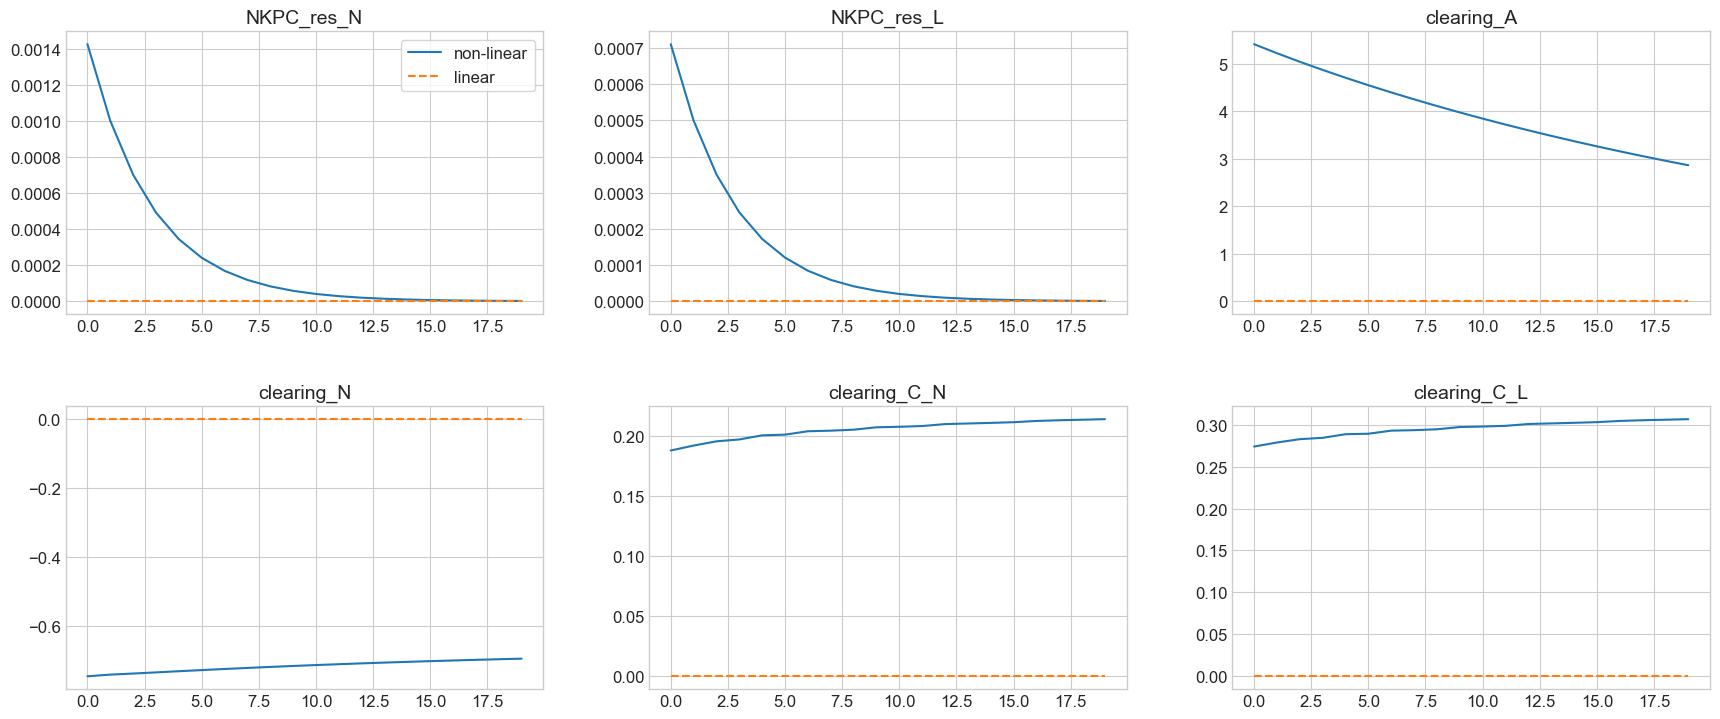

In [15]:
paths = ['C']
model.show_IRFs(paths,T_max=20,ncols=3,do_linear=True)

# Step 4. Simulation

In [16]:
np.random.seed(1917)
model.simulate(do_print=True)

KeyboardInterrupt: 

In [ ]:
def model_sim():
    
    fig = plt.figure(figsize=(12,8),dpi=100)

    ax = fig.add_subplot(2,2,1)
    ax.set_title('i')
    ax.plot(ss.i+sim.di,ls='--')
    ax.axhline(ss.i,color='black',zorder=0)

    ax = fig.add_subplot(2,2,2)
    ax.set_title('pi')
    ax.plot(ss.pi+sim.dpi,ls='--',)
    ax.axhline(ss.pi,color='black',zorder=0)
    
    ax = fig.add_subplot(2,2,3)
    ax.set_title('r')
    ax.plot(ss.r+sim.dr,ls='--',)
    ax.axhline(ss.r,color='black',zorder=0)
    
    ax = fig.add_subplot(2,2,4)
    ax.set_title('C')
    ax.plot(ss.C+sim.dC,ls='--',)
    ax.axhline(ss.C,color='black',zorder=0)
    

In [ ]:
model_sim()